In [ ]:
!pip install tensorflow
!pip install Pillow

# Import Library

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

print(tf.__version__)

2.14.0


# Clone Repo from GitHub

In [2]:
%cd /content
!git clone "https://github.com/Limteckping45/Cos30082_Assignment"

train_txt_path = '/content/Cos30082_Assignment/train.txt'
test_txt_path = '/content/Cos30082_Assignment/test.txt'
train_image_path = '/content/Cos30082_Assignment/Train'
test_image_path = '/content/Cos30082_Assignment/Test'

/content
Cloning into 'Cos30082_Assignment'...
remote: Enumerating objects: 6051, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 6051 (delta 4), reused 1 (delta 0), pack-reused 6040
Receiving objects: 100% (6051/6051), 646.09 MiB | 31.22 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (6039/6039), done.


In [3]:
#Parameters Set
num_class = 200
batch_size = 32
epochs = 11

In [4]:
#Reading the txt file
train_data, test_data = [], []
with open(train_txt_path, 'r') as train_file:
  train_data = train_file.read().splitlines()
with open(test_txt_path, 'r') as test_file:
  test_data = test_file.read().splitlines()

train_df = pd.DataFrame([x.split() for x in train_data], columns = ['filename', 'class'])
test_df = pd.DataFrame([x.split() for x in test_data], columns = ['filename', 'class'])

In [5]:
#Data Augmentation
train_datagen = ImageDataGenerator(
    rescale = 1.0/255.0,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(rescale = 1.0/255.0)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory = train_image_path,
    x_col = 'filename',
    y_col = 'class',
    target_size = (224, 224),
    batch_size = batch_size,
    class_mode = 'categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory = test_image_path,
    x_col = 'filename',
    y_col = 'class',
    target_size = (224, 224),
    batch_size = batch_size,
    shuffle = False,
    class_mode = 'categorical'
)

Found 4829 validated image filenames belonging to 200 classes.
Found 1204 validated image filenames belonging to 200 classes.


In [ ]:
#Model Use (ResNet50)
base_model = ResNet50(weights = 'imagenet', include_top = False)
x = base_model.output
#Reduce the spatial dimentions of the feature maps
x = GlobalAveragePooling2D()(x)
#1024 is the deep of the hidden layers
#Regularizer is to prevent the overfitting and is reduce the image weight
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)
#Improve regularization
x = BatchNormalization()(x)
#Randomly dropout units during each batch
x = Dropout(0.5)(x)
#Output layer
predictions = Dense(num_class, activation = 'softmax')(x)
#Creating model
model = Model(inputs = base_model.input, outputs = predictions)

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
#Model Compile
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#Early Stopping
#Patient is if the val loss not decrease for 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
#Train Model
train_model = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = test_generator,
    validation_steps = test_generator.samples // batch_size,
    epochs = epochs,
    callbacks=[early_stopping]
)

Epoch 1/11
150/150 [==============================] - 140s 627ms/step - loss: 6.9769 - accuracy: 0.0475 - val_loss: 7.5530 - val_accuracy: 0.0059
Epoch 2/11
150/150 [==============================] - 90s 597ms/step - loss: 4.6765 - accuracy: 0.2560 - val_loss: 7.1893 - val_accuracy: 0.0059
Epoch 3/11
150/150 [==============================] - 92s 610ms/step - loss: 3.5260 - accuracy: 0.4699 - val_loss: 7.1311 - val_accuracy: 0.0110
Epoch 4/11
150/150 [==============================] - 91s 604ms/step - loss: 2.8549 - accuracy: 0.6073 - val_loss: 6.9343 - val_accuracy: 0.0177
Epoch 5/11
150/150 [==============================] - 93s 621ms/step - loss: 2.3560 - accuracy: 0.7384 - val_loss: 6.1868 - val_accuracy: 0.0963
Epoch 6/11
150/150 [==============================] - 91s 606ms/step - loss: 2.0364 - accuracy: 0.8155 - val_loss: 5.1642 - val_accuracy: 0.2120
Epoch 7/11
150/150 [==============================] - 94s 629ms/step - loss: 1.7826 - accuracy: 0.8897 - val_loss: 3.7673 - val_a

In [ ]:
#Save trained-model
model.save('bird_classifier.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#Show Accuracy
train_accuracy = train_model.history['accuracy'][-1] * 100
val_accuracy = train_model.history['val_accuracy'][-1] * 100

print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy: {val_accuracy:.2f}%")


Training Accuracy: 96.85%
Test Accuracy: 62.42%


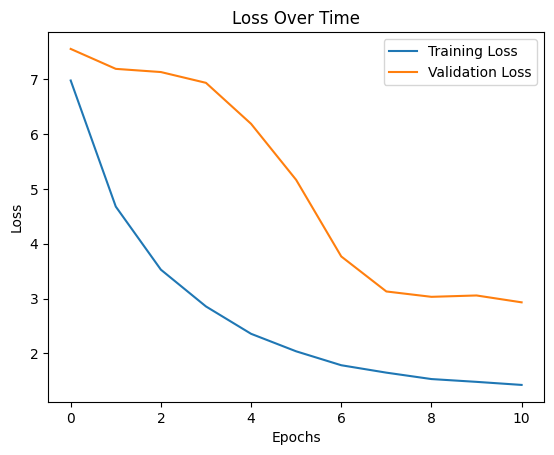

In [ ]:
#Show Loss Overtime Graph
plt.plot(train_model.history['loss'], label = 'Training Loss')
plt.plot(train_model.history['val_loss'], label = 'Validation Loss')
plt.title('Loss Over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

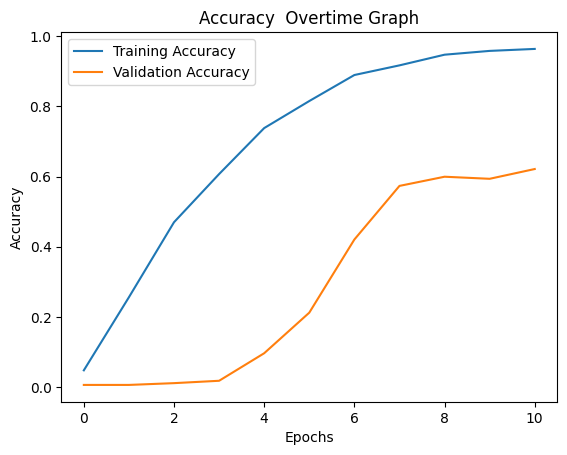

In [ ]:
#Show Accuracy Overtime Graph
plt.plot(train_model.history['accuracy'], label = 'Training Accuracy')
plt.plot(train_model.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Accuracy  Overtime Graph')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Load Model

Upload the bird_classifier.h5 from the zip file to your own google drive

In [6]:
#Access Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
#Load trained model
%cd /content/drive/MyDrive/
model = load_model('bird_classifier.h5')

/content/drive/MyDrive


# Evaluation

In [8]:
from sklearn.metrics import accuracy_score

# Make predictions on the test data
y_pred = model.predict(test_generator)

# Convert one-hot encoded predictions to class labels (e.g., using argmax)
y_pred_labels = np.argmax(y_pred, axis=1)

# Get the true labels from the test generator
y_true = test_generator.classes

# Calculate the Top-1 accuracy
top1_accuracy = accuracy_score(y_true, y_pred_labels)


38/38 [==============================] - 209s 5s/step


In [9]:
from sklearn.metrics import confusion_matrix

# Get the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)

# Calculate class-wise accuracy
class_accuracies = np.diag(conf_matrix) / conf_matrix.sum(axis=1)

# Calculate the average accuracy per class
avg_accuracy_per_class = np.mean(class_accuracies)


In [16]:
#Read and set the class labels
class_name_label_path = '/content/Cos30082_Assignment/class_name_labels.txt'
class_names = []
class_labels = []
with open(class_name_label_path, 'r') as file:
  for line in file:
    parts = line.strip().split()
    class_names.append(parts[0])
    class_labels.append(parts[1])
#class_names = class_names
#class_labels = class_labels

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

# Calculate precision, recall, and F1-score
report = classification_report(y_true, y_pred_labels, target_names=class_names)

# Print the Top-1 accuracy, Average accuracy per class, and the classification report
print(f"Top-1 Accuracy: {top1_accuracy * 100 :.2f}%")
print(f"Average Accuracy per Class: {avg_accuracy_per_class * 100 :.2f}%")
print("\nClassification Report:")
print(report)
print("\nConfusion Matrix:")
print(conf_matrix)


Top-1 Accuracy: 62.13%
Average Accuracy per Class: 61.36%

Classification Report:
                                precision    recall  f1-score   support

        Black_footed_Albatross       0.67      0.57      0.62         7
              Laysan_Albatross       0.50      0.40      0.44         5
               Sooty_Albatross       1.00      0.20      0.33         5
             Groove_billed_Ani       0.75      0.60      0.67         5
                Crested_Auklet       0.40      0.29      0.33         7
                  Least_Auklet       0.50      0.20      0.29         5
               Parakeet_Auklet       0.57      0.67      0.62         6
             Rhinoceros_Auklet       0.00      0.00      0.00         4
              Brewer_Blackbird       1.00      1.00      1.00         6
          Red_winged_Blackbird       1.00      0.20      0.33         5
               Rusty_Blackbird       0.67      1.00      0.80         6
       Yellow_headed_Blackbird       0.80      0.67  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
